<a href="https://colab.research.google.com/github/akinoriosamura/tensorflow2.0-sample/blob/master/tensorlfow2_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvcc --version

In [0]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (19.1.1)


In [0]:
!pip install tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 52kB/s 
     |████████████████████████████████| 501kB 38.9MB/s 
     |████████████████████████████████| 3.1MB 39.8MB/s 


In [0]:
import tensorflow as tf
tf.__version__

'2.0.0-beta1'

In [0]:
import numpy as  np
import tensorflow as tf
from sklearn.utils import shuffle

class DataLoader(object):
  def __init__(self, dataset, batch_size=100, shuffle=False, random_state=None):
    self.dataset = list(zip(dataset[0], dataset[1]))
    self.batch_size = batch_size
    self.shuffle = shuffle
    if random_state is None:
      random_state = np.random.RandomState(1234)
    self.random_state = random_state
    self._idx = 0
    self._reset()
    
  def __len__(self):
    N = len(self.dataset)
    b = self.batch_size
    
    return N // b + bool(N % b) # num of iter in one epoch
  
  def __iter__(self):
    return self
    
  def __next__(self):
    if self._idx >= len(self.dataset):
      self._reset()
      raise StopIteration()
    x, y = zip(*self.dataset[self._idx:(self._idx + self.batch_size)])
    
    x = tf.convert_to_tensor(x)
    y = tf.convert_to_tensor(y)
    
    self._idx += self.batch_size
    
    return x, y
  
  def _reset(self):
    if self.shuffle:
      self.dataset = shuffle(self.dataset, random_state=self.random_state)
    
    self._idx = 0

Epoch: 1, Cost: 0.323
Epoch: 2, Cost: 0.300
Epoch: 3, Cost: 0.289
Epoch: 4, Cost: 0.283
Epoch: 5, Cost: 0.279
Epoch: 6, Cost: 0.276
Epoch: 7, Cost: 0.274
Epoch: 8, Cost: 0.272
Epoch: 9, Cost: 0.271
Epoch: 10, Cost: 0.269


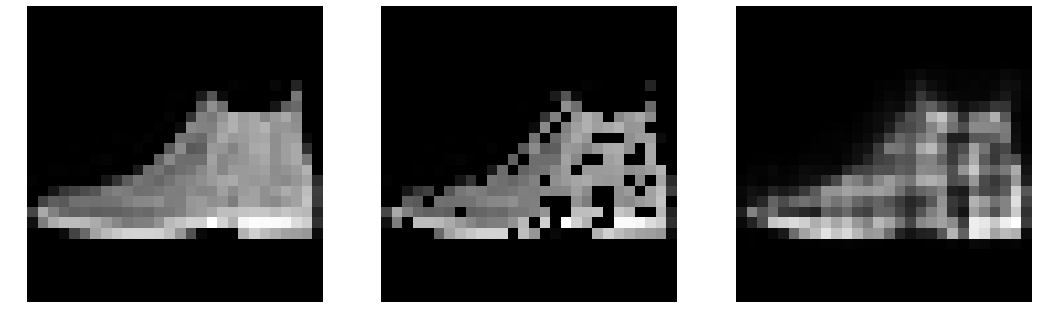

In [42]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
# import DataLoader
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

class Autoencoder(Model):
  def __init__(self):
    super().__init__()
    self.l1 = Dense(200, activation='relu')
    self.l2 = Dense(784, activation='sigmoid')
    
  def call(self, x):
    # encode
    h = self.l1(x)
    
    # decode
    y = self.l2(h)
    
    return y
  
if __name__ == '__main__':
  np.random.seed(1234)
  tf.random.set_seed(1234)
  """
  1, load data
  """
  mnist = datasets.fashion_mnist
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  # ２次元[28 * 28] データを -> 一次元[784]に
  x_train = (x_train.reshape(-1, 784) / 255).astype(np.float32)
  x_test = (x_test.reshape(-1, 784) / 255).astype(np.float32)
  
  train_dataloader = DataLoader((x_train, y_train), batch_size=100, shuffle=True)
  test_dataloader = DataLoader((x_test, y_test), batch_size=1, shuffle=False)
  
  """
  2, build model
  """
  model = Autoencoder()
  
  """
  3, train model
  """
  criterion = tf.losses.BinaryCrossentropy()
  optimizer = optimizers.Adam()
  
  @tf.function
  def compute_loss(x, preds):
    return criterion(x, preds)
  
  @tf.function
  def train_step(x):
    with tf.GradientTape() as tape:
      preds = model(x)
      loss = compute_loss(x, preds)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_loss(loss)
  
  train_loss = metrics.Mean()
  epochs = 10
  
  for epoch in range(epochs):
    # autoencoderなので入力=正解
    # __iter__, __next__はforで自動で呼ばれる
    for (x, _) in train_dataloader:
      train_step(x)
      
    print('Epoch: {}, Cost: {:.3f}'.format(epoch+1, train_loss.result()))
    
  """
  4, test model
  """
  x, _ = next(iter(test_dataloader))
  noise = tf.convert_to_tensor(
      np.random.binomial(1, 0.8, size=(x.numpy().shape)).astype(np.float32)
  )
  x_noise = x * noise
  
  x_reconstructed = model(x_noise)
  
  plt.figure(figsize=(18, 6))
  for i, image in enumerate([x, x_noise, x_reconstructed]):
    image = image.numpy().reshape(28, 28)
    plt.subplot(1, 3, i+1)
    plt.imshow(image, cmap='binary_r')
    plt.axis('off')
  plt.show()

In [43]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17659835274180462239, name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1687149217264305993
 physical_device_desc: "device: XLA_GPU device", name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9471533234796251306
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11326753997
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7206234264524473291
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]